In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Model

In [5]:
#get the user inputs
alpha, rod_length, time_interval = map(int,input( "Please enter the followings in order: alpha , the length of the rod and the specific time interval : ").split())
initial_temp = float(input("Please enter the initial temperature of the rod: "))
top_temp = float(input("Please enter the temperature of the top of the rod: "))
bottom_temp = float(input("Please enter the temperature at the bottom of the rod: "))

Please enter the followings in order: alpha , the length of the rod and the specific time interval : 1 5 1
Please enter the initial temperature of the rod: 50
Please enter the temperature of the top of the rod: 100
Please enter the temperature at the bottom of the rod: 0


In [3]:
# Generate training data
#Training data is generated based on the user inputs
time_interval = float(time_interval)
rod_length = float(rod_length)
alpha = float(alpha)
num_col = 800  # Collocation points
num_bound = 100  # Boundary points
num_con = 100  # Initial condition points
torch.manual_seed(42)
XCOL = torch.rand((num_col, 1), dtype=torch.float32, requires_grad=True) * time_interval
TCOL = torch.rand((num_col, 1), dtype=torch.float32, requires_grad=True) * time_interval
XCOL, TCOL = XCOL.to(device), TCOL.to(device)
'''*******************'''
XBound = torch.cat([torch.zeros((num_bound, 1)), rod_length * torch.ones((num_bound, 1))], dim=0).to(device)
TBound = torch.rand((2 * num_bound, 1), dtype=torch.float32) * time_interval
UBound = torch.cat([torch.full((num_bound, 1), bottom_temp), torch.full((num_bound, 1), top_temp)], dim=0).to(device)
XBound, TBound, UBound = XBound.to(device), TBound.to(device), UBound.to(device)
'''*******************'''
XCon = torch.rand((num_con, 1), dtype=torch.float32, requires_grad=True) * time_interval
TCon = torch.zeros((num_con, 1), dtype=torch.float32, requires_grad=True)
UCon = torch.full((num_con, 1), initial_temp).to(device)
XCon, TCon, UCon = XCon.to(device), TCon.to(device), UCon.to(device)


In [4]:
# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.net(inputs)
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# Define the loss function
def loss_function(model, x, t, XBound, TBound , UBound, XCon, TCon, UCon, alpha):
    #the loss function is based on the formula we use for solving heat transfer PDEs
    #It consists of 3 parts
    #PDE loss is computed based on the derivates of u
    u = model(x, t)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    #PDE loss is computed based on the derivates of u, with respect to time and location on the x-axis
    pde_loss = torch.mean((u_t - alpha * u_xx) ** 2)
    #BC loss is obtained bt getting the Mean Squared Error of the boundary points(get the error using the actual temp of the boundary points and their predicted temps)
    bound_predicted = model(XBound, TBound)
    bound_loss = torch.mean((bound_predicted - UBound) ** 2)
    #Same as BC loss, except it takes initial condition points into consideration
    UCON_predicted = model(XCon, TCon)
    con_loss = torch.mean((UCON_predicted - UCon) ** 2)
    total_loss = pde_loss + bound_loss + con_loss
    return total_loss

In [7]:
#Training
loss_values = []
num_epochs = 4000
for epoch in range(1,num_epochs+1):
    start_time = time.time()
    optimizer.zero_grad()
    loss = loss_function(model, XCOL, TCOL, XBound, TBound, UBound, XCon, TCon, UCon, alpha)
    loss_values.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
    elapsed_time = time.time() - start_time

    print(f"Epoch: {epoch}/{num_epochs} Training Loss: {loss.data:.4f} Time Spent: {elapsed_time:.2f} seconds")

Epoch: 1/4000 Training Loss: 7528.4185 Time Spent: 0.13 seconds
Epoch: 2/4000 Training Loss: 7510.0654 Time Spent: 0.02 seconds
Epoch: 3/4000 Training Loss: 7491.8623 Time Spent: 0.01 seconds
Epoch: 4/4000 Training Loss: 7473.6831 Time Spent: 0.01 seconds
Epoch: 5/4000 Training Loss: 7455.4849 Time Spent: 0.01 seconds
Epoch: 6/4000 Training Loss: 7437.2480 Time Spent: 0.01 seconds
Epoch: 7/4000 Training Loss: 7418.9243 Time Spent: 0.01 seconds
Epoch: 8/4000 Training Loss: 7400.4331 Time Spent: 0.01 seconds
Epoch: 9/4000 Training Loss: 7381.6826 Time Spent: 0.01 seconds
Epoch: 10/4000 Training Loss: 7362.5918 Time Spent: 0.01 seconds
Epoch: 11/4000 Training Loss: 7343.0977 Time Spent: 0.01 seconds
Epoch: 12/4000 Training Loss: 7323.1553 Time Spent: 0.01 seconds
Epoch: 13/4000 Training Loss: 7302.7373 Time Spent: 0.01 seconds
Epoch: 14/4000 Training Loss: 7281.8330 Time Spent: 0.01 seconds
Epoch: 15/4000 Training Loss: 7260.4424 Time Spent: 0.01 seconds
Epoch: 16/4000 Training Loss: 7238

#Visualization

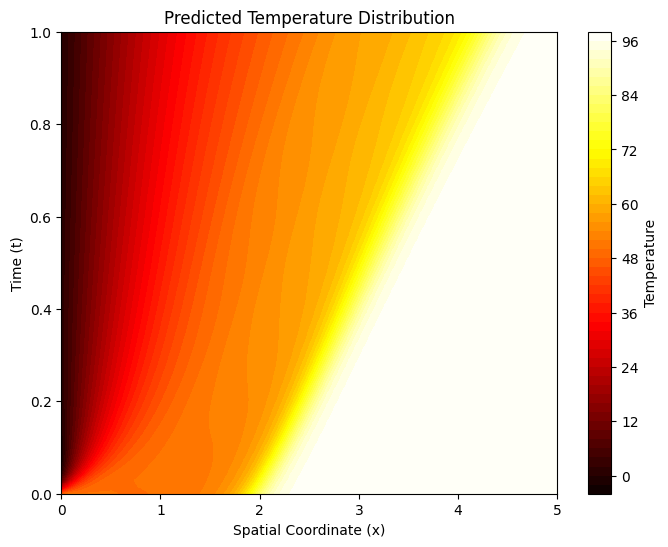

In [11]:
# Generate test data
x_test = torch.linspace(0, rod_length, 70, dtype=torch.float32).unsqueeze(1).to(device)
t_test = torch.linspace(0, time_interval, 70, dtype=torch.float32).unsqueeze(1).to(device)
x_test_grid, t_test_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
x_test, t_test = x_test_grid.reshape(-1, 1), t_test_grid.reshape(-1, 1)
x_test, t_test = x_test.to(device), t_test.to(device)
# Predict using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    u_pred = model(x_test, t_test).cpu().numpy()
# Convert the predicted temperatures to a 2D array for visualization
u_pred = u_pred.reshape(70, 70)
plt.figure(figsize=(8, 6))
plt.contourf(x_test.cpu().numpy().reshape(70, 70), t_test.cpu().numpy().reshape(70, 70), u_pred, levels=50, cmap='hot')
plt.colorbar(label='Temperature')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Time (t)')
plt.title('Predicted Temperature Distribution')
plt.show()


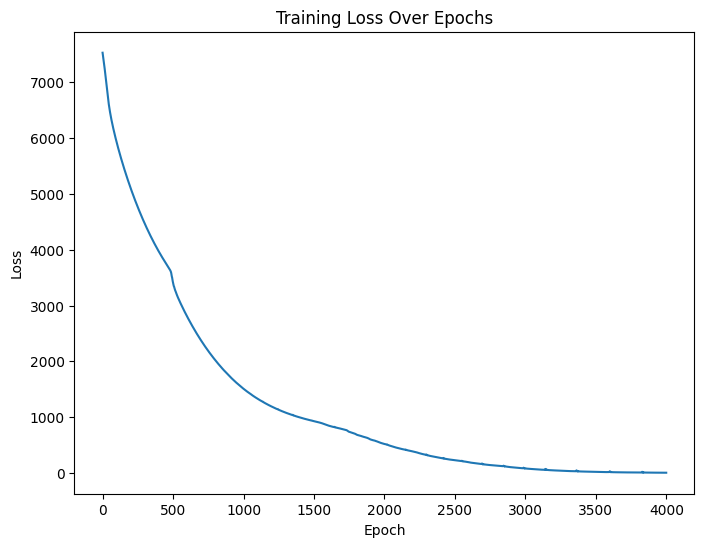

In [12]:
# Plot the training loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()
